In [1]:
# EDA of the CrisisBench dataset

In [10]:
import os
import random
import sys
sys.path.append("../src")

import numpy as np
import pandas as pd
!pip install matplotlib
import matplotlib.pyplot as plt
data_path = "../data/data/all_data_en"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Informativeness

Binary labels: "not_informative", "informative"

In [2]:
!pip install emoji nltk
from src.TweetNormalizer import normalizeTweet


filepath = os.path.join(data_path, "crisis_consolidated_informativeness_filtered_lang_en_train.tsv")
label_enum_dict = {cls: i for i, cls in enumerate(["not_informative", "informative"])}
df = pd.DataFrame([], columns=["text", "label"])
with open(filepath, "r", newline=None, encoding='utf-8', errors='replace') as f:
    next(f)  # skip head col
    for i, line in enumerate(f):
        line = line.strip()
        if line == "":
            continue
        row = line.split('\t')
        text = row[3].strip()
        text = normalizeTweet(text)
        label = row[6]
        label = label_enum_dict[label]
        df.loc[i, :] = [text, label]

In [4]:
df

,text,label
0,"Organization that are working in Haiti , I do ...",1
1,Maria now a hurricane again ! ! Strong storm s...,1
2,RT @user : Fallen tree branches scattered in S...,1
3,The Government did not request international a...,1
4,Remove http Browser Hijacker - How t ... http,0
...,...,...
109791,"On Saturday 22 , ' Alberta ' was Trending Topi...",1
109792,#CHINA uses its massive army to frighten it 's...,0
109793,"In Post-Hurricane Puerto Rico , This Used Game...",0
109794,@user just chilling with Z ... Jimmy Jazz is n...,0


In [5]:
df.describe()

,text,label
count,109796,109796
unique,109796,2
top,"Organization that are working in Haiti , I do ...",1
freq,1,65826


In [6]:
df[df["label"] == 1].count()

text     65826
label    65826
dtype: int64

In [3]:
# Get only crisis-related tweets
df_informative = df[df["label"] == 1].copy()

In [8]:
print("Num characters")
df_informative["text"].str.len().describe()

Num characters


count    65826.000000
mean       105.455823
std         50.745208
min          9.000000
25%         78.000000
50%        104.000000
75%        126.000000
max       4248.000000
Name: text, dtype: float64

In [9]:
print("Num words")
df_informative["text"].str.split().\
    map(lambda x: len(x)).describe()

Num words


count    65826.000000
mean        19.763194
std          9.438799
min          2.000000
25%         14.000000
50%         19.000000
75%         24.000000
max        736.000000
Name: text, dtype: float64

In [ ]:
from collections import Counter
# five most common tokens
word_freq = Counter([word for sentence in df_informative["text"].str.split() for word in sentence])
common_words = word_freq.most_common(100)
common_words


# Explore tokenized text lengths

In [35]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
tokenized_texts = [tokenizer(txt,
                         padding=False,
                         truncation=True, max_length=None) for txt in df_informative["text"]]


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
num_tokens = [sum(x != 0 for x in tokenized_texts[i]["input_ids"]) for i in range
(len(tokenized_texts))]

In [37]:
pd.Series(num_tokens).describe()

count    65826.000000
mean        23.763604
std          9.399922
min          3.000000
25%         17.000000
50%         23.000000
75%         29.000000
max        127.000000
dtype: float64

In [39]:
tokenized_texts

[{'input_ids': [0, 17580, 25, 41, 558, 16, 22750, 7, 8, 32, 46, 36, 207, 1430, 15, 602, 356, 15, 23, 383, 137, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 7179, 77, 11, 12012, 206, 12, 12, 6792, 3260, 20505, 17, 74, 1402, 16, 3934, 987, 3094, 17585, 15650, 15650, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 246, 5238, 4699, 22, 28723, 2778, 17363, 25105, 16, 9081, 2266, 1803, 831, 20, 3937, 4, 30669, 3819, 8946, 57, 1439, 156, 5238, 4699, 60, 15650, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [0, 47, 3521, 1

# Explore meta info

In [3]:
filepath = os.path.join(data_path, "crisis_consolidated_informativeness_filtered_lang_en_train.tsv")
label_enum_dict = {cls: i for i, cls in enumerate(["not_informative", "informative"])}
df = pd.DataFrame([], columns=["event", "source", "lang", "lang_conf", "label"])
with open(filepath, "r", newline=None, encoding='utf-8', errors='replace') as f:
    next(f)  # skip head col
    for i, line in enumerate(f):
        line = line.strip()
        if line == "":
            continue
        row = line.split('\t')
        event = row[1]
        source = row[2]
        lang = row[4]
        lang_conf = row[5]
        label = row[6]
        label = label_enum_dict[label]
        df.loc[i, :] = [event, source, lang, lang_conf, label]

In [4]:
df.head()

,event,source,lang,lang_conf,label
0,disaster_events,drd-figureeight-multimedia,en,1,1
1,hurricane_maria,crisismmd,en,NA,1
2,2014_philippines_typhoon,crisisnlp-cf,en,0.9505285620689392,1
3,disaster_events,drd-figureeight-multimedia,en,1,1
4,disaster_events,dsm-cf,en,1,0


In [45]:
df_informative = df[df["label"] == 1].copy()

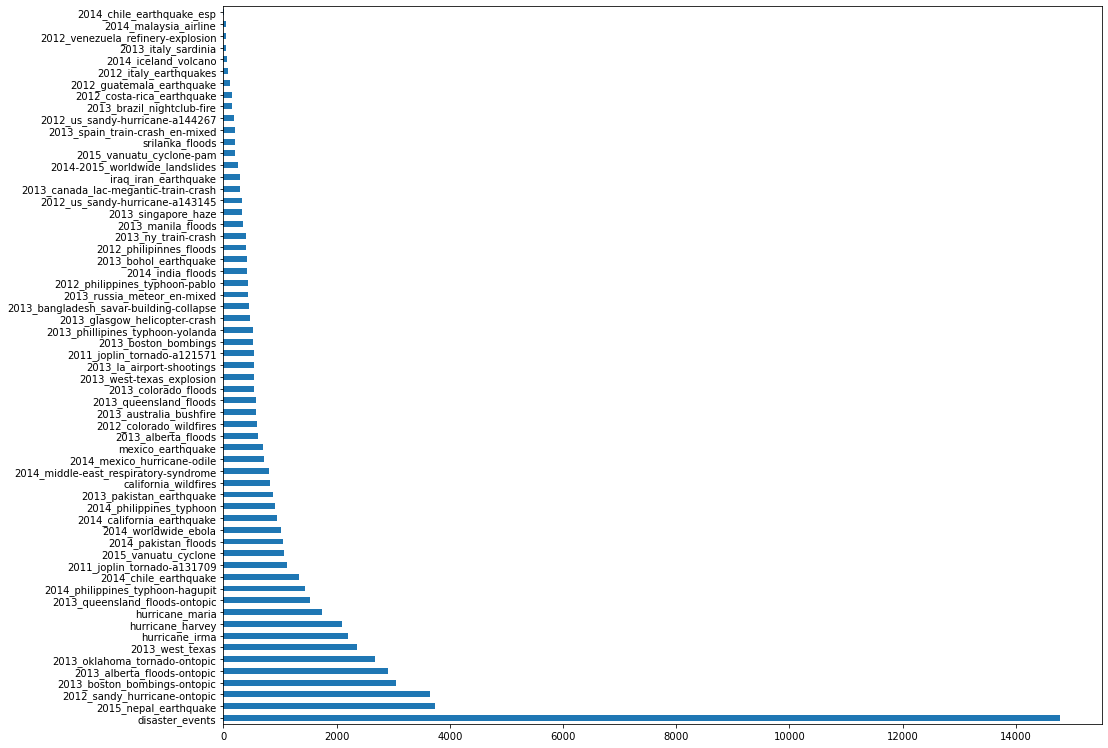

In [16]:
# Types of events by frequency (for informative tweets)
df_informative.event.value_counts().plot(kind="barh")
plt.gcf().set_size_inches(15.5, 10.5)
plt.tight_layout()


Examples for "disaster_events" type:
* A new pollution scare struck central China on Wednesday when a chemical tanker trunk fell off a
ferry and plunged into a tributary of the Yangtze River, leaking some of the 20 tonnes of basic aqueous alkali it was carrying to flow into the water.
* From Feb. 9 to 13, meteorological department seized opportunities to carry out snow enhancement.
* On the Pakistani side, a medical team of seven doctors and two paramedics arrived on October 12
in Balakot, and ten trucks carrying food, tents, blankets and medical supplies reached yesterday.

<AxesSubplot:>

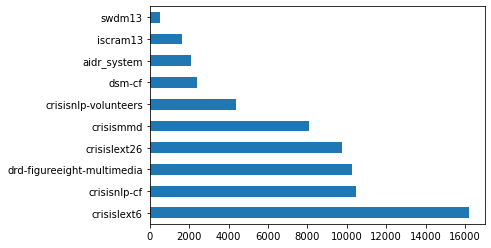

In [17]:
df_informative.source.value_counts().plot(kind="barh")

<AxesSubplot:>

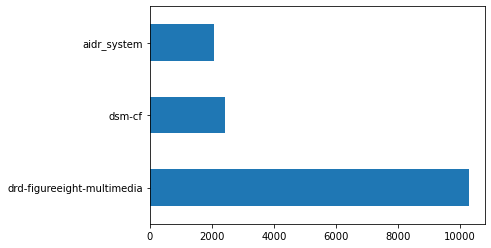

In [24]:
df_informative.loc[df_informative["event"] == "disaster_events", "source"].value_counts().plot\
    (kind="barh")

<AxesSubplot:>

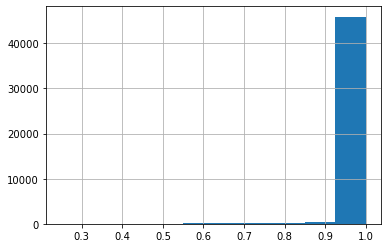

In [46]:
df_informative["lang_conf"] = df_informative["lang_conf"].replace('NA', np.nan)
df_informative["lang_conf"].astype("float").hist()

In [52]:
sum(df_informative["lang_conf"].isna())
# several "NA" for language confidence, but affected sentences are still English (upon eyeballing)

19011

In [63]:
# Trying out a way to get rid of undecodable chars
sentence = "This is a funky sentence ��_ â¤ï¸ �۝ "
sentence.encode('ascii','ignore').decode("ascii")

'This is a funky sentence _   '